In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 



In [41]:
df = pd.read_csv('../Data/data.csv', encoding='LATIN1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [42]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [43]:
df=df.dropna(axis=0).reset_index()
df.shape

(406829, 9)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


# RFM Segmentation

Questions:

1. What percentage of customers are high-value? i.e. High Recency, Frequency and Monetary
2. What percentage of High-value customers are at Churn-risk? i.e. High Frequency and Monetary, low Recency
3. What is the spending period of cycle of high-value customers?


In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [ ]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)


In [ ]:
rfm.reset_index().to_csv('rfm_output.csv', index=False)


# Cohort Analysis

Questions:

1. What is the post onboarding customer-retention rate?
2. What months observed highest retention?
3. Did retention rate exhibit any anomaly for any particular onboarding month? Effect of some campaign?
4. What kind of seasonality and purchase cycle does the data exhibit?

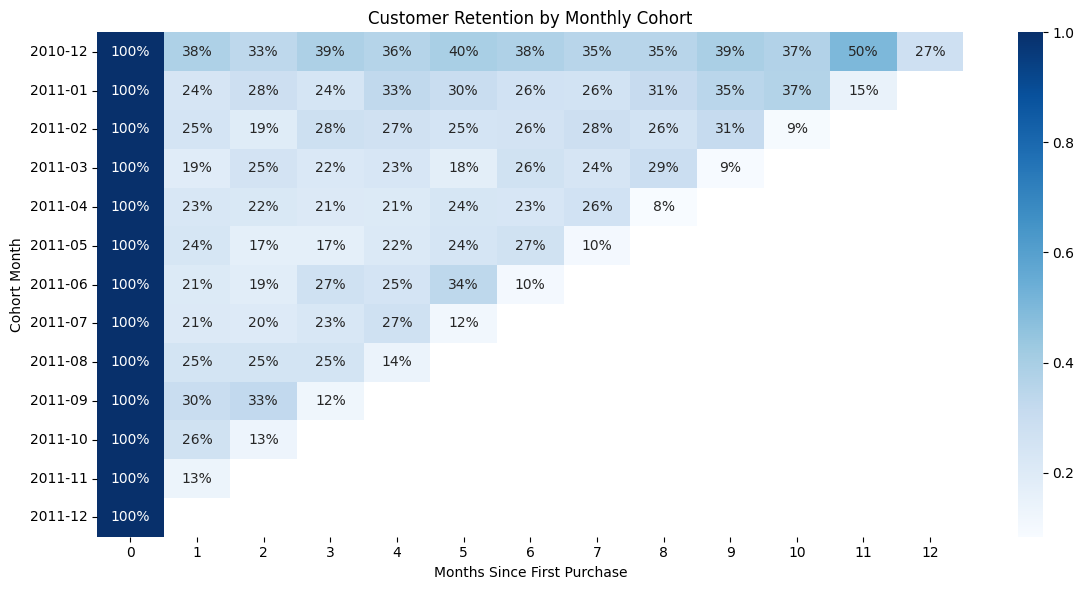

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# ---Create time-based labels ---
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Convert Periods to timestamps for date math
df['OrderMonthTS'] = df['OrderMonth'].dt.to_timestamp()
df['CohortMonthTS'] = df['CohortMonth'].dt.to_timestamp()

# ---Calculate Cohort Index---
def get_month_diff(start, end):
    return (end.year - start.year) * 12 + (end.month - start.month)

df['CohortIndex'] = df.apply(
    lambda row: get_month_diff(row['CohortMonthTS'], row['OrderMonthTS']),
    axis=1
)

# --- Build the cohort table (customer counts) ---
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# --- Calculate retention rate (% of original cohort) ---
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# --- retention heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Customer Retention by Monthly Cohort')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()

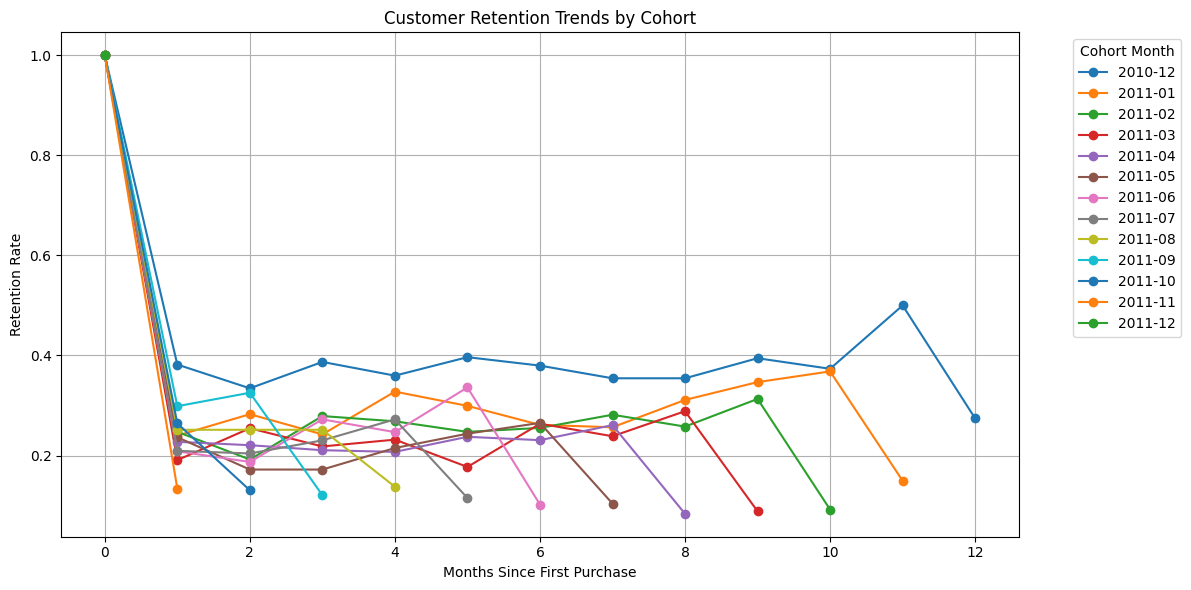

In [ ]:
#--- Customer Trends by Cohort ------

plt.figure(figsize=(12, 6))

for i in retention.index:
    plt.plot(retention.columns, retention.loc[i], marker='o', label=str(i))

plt.title('Customer Retention Trends by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
# Save retention matrix
retention_csv = retention.copy() * 100
retention_csv.to_csv("cohort_retention_matrix.csv")

# Save cohort size (column 0)
cohort_counts.iloc[:, 0].to_frame(name='CohortSize').to_csv("cohort_sizes.csv")

# Save trend table (melted format for line chart)
retention_long = retention.reset_index().melt(id_vars='CohortMonth', var_name='CohortIndex', value_name='Retention')
retention_long['Retention'] = retention_long['Retention'] * 100
retention_long.to_csv("retention_trends.csv", index=False)


In [51]:
# Compute revenue per transaction
df['Revenue'] = df['UnitPrice'] * df['Quantity']


In [52]:
# Group by CohortMonth and CohortIndex, summing revenue
revenue_data = df.groupby(['CohortMonth', 'CohortIndex'])['Revenue'].sum().reset_index()

# Pivot into a cohort matrix
revenue_cohort = revenue_data.pivot(index='CohortMonth', columns='CohortIndex', values='Revenue')


In [54]:
# Save to CSV for import into Power BI
revenue_cohort.to_csv("cohort_revenue_matrix.csv")
revenue_data.to_csv("Rev_cohort.csv", index=False)